## TO DO

In [ ]:
!curl ipinfo.io


{
  "ip": "35.222.138.236",
  "hostname": "236.138.222.35.bc.googleusercontent.com",
  "city": "Council Bluffs",
  "region": "Iowa",
  "country": "US",
  "loc": "41.2619,-95.8608",
  "org": "AS396982 Google LLC",
  "postal": "51502",
  "timezone": "America/Chicago",
  "readme": "https://ipinfo.io/missingauth"
}

In [ ]:
import pandas as pd
import json
import requests
from bs4 import BeautifulSoup
import time
import random
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df_cooking = pd.read_json('https://wizard-of-tasks.s3.us-west-2.amazonaws.com/wizard_of_tasks_cooking_v1.0.json')
df_diy = pd.read_json('https://wizard-of-tasks.s3.us-west-2.amazonaws.com/wizard_of_tasks_diy_v1.0.json')

In [ ]:
load_fresh = True
if load_fresh:
    df_raw = pd.DataFrame([], columns=['domain', 'conversation', 
                                'document_url', 
                                'data_split', 
                                'text', 
                                'turn_counter', 
                                'dangerous_tools',
                                'shared_data',
                                'intent',
                                'real_life_action',
                                'useful',
                                'worker_id',
                                'previous_worker_id',
                                'role'
                                ])

    for col in df_cooking.columns:
        turns = df_cooking[col].turns
        for turn in turns:
            entry = turn.copy()
            entry['domain'] = 'cooking'
            entry['conversation'] = col
            entry['document_url'] = df_cooking[col].document_url
            entry['data_split'] = df_cooking[col].data_split
            df_raw = df_raw.append(entry, ignore_index=True)

    for col in df_diy.columns:
        turns = df_diy[col].turns
        for turn in turns:
            entry = turn.copy()
            entry['domain'] = 'diy'
            entry['conversation'] = col
            entry['document_url'] = df_diy[col].document_url
            entry['data_split'] = df_diy[col].data_split
            df_raw = df_raw.append(entry, ignore_index=True)

    #df_raw.to_csv('/content/data_raw.csv', index=False)
else:
    df_raw = pd.read_csv('/content/data_raw.csv')

In [ ]:
df_raw['turn_counter'] = df_raw['turn_counter'].astype(int)
df_raw['shared_data'] = df_raw['shared_data'].astype(str)
df_raw['turn_id'] = np.arange(df_raw.shape[0])
df_raw.dtypes

domain                object
conversation          object
document_url          object
data_split            object
text                  object
turn_counter           int64
dangerous_tools       object
shared_data           object
intent                object
real_life_action      object
useful                object
worker_id             object
previous_worker_id    object
role                  object
relevant              object
external_urls         object
turn_id                int64
dtype: object

In [ ]:
df_raw = df_raw
# df_raw['text'] = df_raw['text'] + df_raw['shared_data'].astype(str)
df_raw['text'] = df_raw['text'].str.replace('[', '')
df_raw['text'] = df_raw['text'].str.replace(']', '')

<ipython-input-7-78b0438e7d67>:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_raw['text'] = df_raw['text'].str.replace('[', '')
<ipython-input-7-78b0438e7d67>:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_raw['text'] = df_raw['text'].str.replace(']', '')


In [ ]:
df_raw['intent'].unique()

array(['ask_question_ingredients_tools', 'return_list_ingredients_tools',
       'request_next_step', 'return_next_step', 'ask_student_question',
       'ask_question_recipe_steps', 'answer_question_recipe_steps',
       'answer_question_external_fact', 'stop', 'chitchat', 'misc'],
      dtype=object)

In [ ]:
df_test = df_raw
df_test = df_test[df_test['intent']=='answer_question_recipe_steps']
#df_test = df_test[df_test['domain']=='cooking']
df_test = df_test[df_test['useful']=='yes']
df_test = df_test[df_test['relevant']=='yes']
df_test.shape

(1540, 17)

In [ ]:
df_test = df_raw[df_raw['intent'].isin(['ask_question_ingredients_tools', 'ask_question_recipe_steps'])]
df_test = df_test[df_test['domain']=='cooking']
df_test = df_test[df_test['useful']=='yes']
df_test = df_test[df_test['relevant']=='yes']
df_test = df_test[df_test['data_split']=='train']
#df_test['dangerous_tools'] = df_test['dangerous_tools'].astype(str)
#df_test = df_test[df_test['dangerous_tools']=='[]']
df_test

,domain,conversation,document_url,data_split,text,turn_counter,dangerous_tools,shared_data,intent,real_life_action,useful,worker_id,previous_worker_id,role,relevant,external_urls,turn_id
19,cooking,Wizard-of-Task-food-2,https://www.wholefoodsmarket.com/recipes/cream...,train,How much cream cheese and other ingredients wi...,1,[],[],ask_question_ingredients_tools,N/A,yes,203,None,student,yes,NaN,19
21,cooking,Wizard-of-Task-food-2,https://www.wholefoodsmarket.com/recipes/cream...,train,What are the few other ingredients?,3,"[1 package cream cheese, softened]",[],ask_question_recipe_steps,Take it out all ingredients.,yes,228,129,student,yes,NaN,21
30,cooking,Wizard-of-Task-food-3,https://www.wholefoodsmarket.com/recipes/citru...,train,Will I be using premade pasta from the box or ...,1,[],[],ask_question_ingredients_tools,N/A,yes,2,None,student,yes,NaN,30
32,cooking,Wizard-of-Task-food-3,https://www.wholefoodsmarket.com/recipes/citru...,train,Okay and what other ingredients do I need?,3,[],[],ask_question_ingredients_tools,Think about what type of pasta shape I want,yes,124,153,student,yes,NaN,32
34,cooking,Wizard-of-Task-food-3,https://www.wholefoodsmarket.com/recipes/citru...,train,I am all out of garlic-infused olive oil. Is r...,5,[],[],ask_question_recipe_steps,I will get sea salt and the other ingredients ...,yes,145,22,student,yes,NaN,34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7872,cooking,Wizard-of-Task-food-271,https://www.wholefoodsmarket.com/recipes/cream...,train,How long should I boil the broth for?,13,[],[],ask_question_recipe_steps,I would bring the broth to a boil.,yes,2,22,student,yes,NaN,7872
7876,cooking,Wizard-of-Task-food-271,https://www.wholefoodsmarket.com/recipes/cream...,train,"Hmm, how long is a bit? Like 2 minutes?",17,[],[],ask_question_recipe_steps,Take dish off heat.,yes,64,157,student,yes,NaN,7876
7880,cooking,Wizard-of-Task-food-271,https://www.wholefoodsmarket.com/recipes/cream...,train,What does Fluff mean?,21,[],[],ask_question_recipe_steps,Cool it for a few min.,yes,64,157,student,yes,NaN,7880
7888,cooking,Wizard-of-Task-food-271,https://www.wholefoodsmarket.com/recipes/cream...,train,How can I know when it's properly smooth?,29,[],[],ask_question_recipe_steps,Use food processor.,yes,64,15,student,yes,NaN,7888


## Extract from paper
As input, we provide the models the user
question and a context, which consist of document
(recipe or article) text, a list of ingredients or tools
associated with the document, and the prior conversational history

In [ ]:
load_fresh = True
history_length = 4
if load_fresh:
    df_answers = df_raw[df_raw['intent']=='answer_question_recipe_steps']
    df_answers = df_answers[df_answers['useful']=='yes']
    df_answers = df_answers[df_answers['relevant']=='yes']
    df_answers = df_answers.rename(columns = {'text':'answer'})

    df_questions = df_raw[df_raw['useful']=='yes']
    df_questions = df_questions[df_questions['relevant']=='yes']
    df_questions = df_raw[df_raw['intent'].isin(['ask_question_ingredients_tools', 'ask_question_recipe_steps'])]
    df_questions = df_questions[['conversation', 'text', 'turn_id']].rename(columns = {'text':'question'})
    df_questions['turn_id'] = df_questions['turn_id'] + 1
    df_questions = df_questions.merge(df_answers, how='inner', on=['conversation', 'turn_id'])

    # create history
    #history = []
    #for i,row in df_questions.iterrows():
    #    df_temp = df_raw[df_raw['conversation']==row['conversation']]
    #    df_temp = df_temp[(df_temp['turn_counter']>row['turn_counter']-history_length) & (df_temp['turn_counter']<row['turn_counter'])].sort_values('turn_counter')
    #    hist = []
    #    for j,r in df_temp.iterrows():
    #        hist.append(f"{r['role']}: {r['text']}")
    #    history.append(';'.join(hist))
    #df_questions['history'] = history

    #df = df_questions[['document_url', 'data_split', 'question', 'answer', 'history', 'domain']]
    df = df_questions[['document_url', 'data_split', 'question', 'answer', 'domain']]

    df.to_csv('/content/data.csv', index=False)
else:
    df = pd.read_csv('/content/data.csv')
df

,document_url,data_split,question,answer,domain
0,https://www.wholefoodsmarket.com/recipes/labne...,test,Can I let the ingredients sit for longer to ma...,Only 15 minutes is needed for the flavors to m...,cooking
1,https://www.wholefoodsmarket.com/recipes/cream...,train,How much cream cheese and other ingredients wi...,You will need 1 package of cream cheese and a ...,cooking
2,https://www.wholefoodsmarket.com/recipes/cream...,train,What are the few other ingredients?,I attached them to my last message. They are ...,cooking
3,https://www.wholefoodsmarket.com/recipes/citru...,train,Will I be using premade pasta from the box or ...,You will be using premade pasta. The recipe c...,cooking
4,https://www.wholefoodsmarket.com/recipes/grill...,train,Will I be making the tortellini by hand or sho...,You could make it by hand but this recipe incl...,cooking
...,...,...,...,...,...
1150,https://www.wikihow.com/Prune-Dahlias,train,Are flowers that have started to fade already ...,This pruning is to encourage flower growth.,diy
1151,https://www.wikihow.com/Test-a-Diode,train,What is a lead and why are they red and black?,The leads are the cables coming off of the mul...,diy
1152,https://www.wikihow.com/Test-a-Diode,train,What happens if a section doesn't work.,If one of your diodes don't work we are going ...,diy
1153,https://www.wikihow.com/Melt-a-Soap-Bar,train,What happens to the soap if I microwave for to...,If it is heated to long it will ruin the integ...,diy


In [ ]:
import re
def parse_time(time_str):
    class CustomParserInfo(parserinfo):
        HMS = [('h', 'hr', 'hrs', 'hour', 'hours'), ('m', 'min', 'mins', 'minute', 'minutes'),
                ('s', 'second', 'seconds')]

    try:
        parsed_time = dparser.parse(time_str, fuzzy=True, parserinfo=CustomParserInfo())
        parsed_time_min = parsed_time.minute + parsed_time.hour * 60 + parsed_time.second / 60
        return parsed_time_min
    except:
        minutes = ('m', 'min', 'mins', 'minute', 'minutes')
        hours = ('h', 'hr', 'hrs', 'hour', 'hours')
        seconds = ('s', 'second', 'seconds')

        time_num = re.findall(r"\d+", time_str.strip())
        if time_num != []:
            final_time = 0
            time_int = int(time_num[0])
            for word in time_str.split(" "):
                if word in minutes:
                    final_time = time_int
                elif word in hours:
                    final_time = time_int * 60
                elif word in seconds:
                    final_time = time_int / 60

            return final_time
        else:
            return 0


def get_method_number(soup):
        """ Scrape how many methods the DIY article contains and save this number in DIYDocument.number_of_parallel_
        methods
        """
        steps_lists = soup.find_all(class_='steps')
        if steps_lists != []:
            header = steps_lists[0].find('h3')
            if header:
                if "Part" in header.text:
                    # DIY article has parts
                    return 1
                else:
                    # DIY article has methods
                    number = len(steps_lists)
                    return number
            else:
                # DIY article has just one method, no parts
                return 1

def get_steps(soup):
    """ Parse steps. """
    # article just has one method
    list_of_steps_list = soup.find_all('ol', class_='steps_list_2')
    method_number = get_method_number(soup)
    if list_of_steps_list != []:
        # loop through all parts (which include an array of steps) of the article
        if method_number > 1:
            list_of_steps_list = list_of_steps_list[:1]
        for part in list_of_steps_list:
            list_of_steps = get_steps_list(soup, part)
    return list_of_steps

def get_steps_list(soup, steps_list):
    """ Helper function to scrape all steps from list object """
    # Loop over steps object to access associated text, images, or video.
    steps = []
    for step_tag in steps_list.find_all('li'):
        if step_tag.get('id') is not None:
            # Build Step object.
            step_object = step_tag.find(class_='step')
            if step_object:
                # scrape bold step header
                header = step_object.find('b')
                if header:
                    header = header.text

                # scrape all the remaining text after the bold step header
                text = step_object.find_all(text=True)
                if len(text) >= 3:
                    text = text[2]
                    if text[0] == '[':
                        text = ''
                    else:
                        text += ';'
                elif text != []:
                    text = text[0]

                # scrape all step text that is stored in a bulleted list
                step_list_text = step_object.find('ul')
                if step_list_text:
                    for bullet_point in step_list_text.find_all('li'):
                        text += bullet_point.find_all(text=True)[0].strip() + ';'
                steps.append(f'{header}: {text}')
    return steps

In [ ]:
#df_cooking = pd.read_json('https://wizard-of-tasks.s3.us-west-2.amazonaws.com/wizard_of_tasks_cooking_v1.0.json')
#df_diy = pd.read_json('https://wizard-of-tasks.s3.us-west-2.amazonaws.com/wizard_of_tasks_diy_v1.0.json')
#df = pd.concat([df_cooking.transpose(), df_diy.transpose()])
urls = df['document_url'].unique()

content = {}
for i,url in enumerate(urls):
    recipe = {}

    request = requests.get(url)
    html = request.text
    status = request.status_code

    if 'wholefoodsmarket' in url and status == 200:
        soup = BeautifulSoup(html, 'html.parser')
        schema = soup.find_all('script', attrs={"type": "application/ld+json"})
        schema = json.loads(schema[0].string)

        recipe['title'] = soup.find(class_='w-header-title').text
        recipe['description'] = schema['description']
        #recipe['totalTime'] = parse_time(schema.get('totalTime', ''))
        #recipe['servings'] = schema["recipeYield"]

        ingredients = []
        for r in schema.get('recipeIngredient'):
            ingredients.append(r)
        recipe['ingredients'] = ingredients

        steps = []
        for r in schema.get('recipeInstructions'):
            steps.append(r.get('text'))
        recipe['steps'] = steps

        #for ingredient in ingredients:
        #    ingre = ingredient.split(',')[0].split(' ')
        #    
        #    q = ''
        #    if len(ingre) == 2:
        #        
        #        r = random.randint(0, 2)
        #        if r == 0:
        #            q = f'How many  {ingre[1]} should I get?'
        #        elif r == 1:
        #            q = f'How many {ingre[1]} do I need?'
        #        else:
        #            q = f'How many {ingre[1]} should I use?'
        #        a = ingre[0]
        #    
        #    elif len(ingre) > 1 and ingre[1] in ['(7.0-ounce)', '(8.0-ounce)','(14.0-ounce)','(15.0-ounce)', '(20.0-ounce)' ,'(12.0-ounce)', '(9-inch)', '(28.0-ounce)', 'piece', '(6-ounce)', 'whole', 'ounce', 'ounces', 'cloves', 'small', 'large', 'cup', 'cups', 'tablespoon', 'tablespoons', 'teaspoon', 'teaspoons', 'pound','pounds', 'gram','grams', 'g', 'gr', '(750.0-ml)', '(500.0-ml)', '(26.0-ounce)','(8.0-ounce)', '(6.0-ounce)', '(9.0-ounce)']:
        #        r = random.randint(0,1)
        #        if r == 0:
        #            q = f'How much {" ".join(ingre[2:])}, do I need?'
        #        else:
        #            q = f'How much {" ".join(ingre[2:])}, should I use?'
        #        a = ' '.join(ingre[:2])
#
        #    if q != '':
        #        print(f'Q: {q}   A:{a}')
#
#
#

    elif 'wikihow' in url and status == 200:
        soup = BeautifulSoup(html, 'html.parser')
    
        recipe['title'] = soup.find(id='section_0').text
        recipe['description'] = soup.find(id='mf-section-0').text
        #recipe['totalTime'] = ''
        #recipe['servings'] = ''
        recipe['steps'] = get_steps(soup)

    else:
        print(f'Error for : {url}')

    content[url] = recipe


Error for : https://www.wikihow.com/Use-Chia-Seeds


In [ ]:
content['https://www.wikihow.com/Use-Chia-Seeds'] = ''

In [ ]:
context = []
for i, row in df.iterrows():
    context.append(content[row['document_url']])
df['context'] = context
df['context'] = df['context'].astype(str)
df

<ipython-input-18-24023c958239>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['context'] = context
<ipython-input-18-24023c958239>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['context'] = df['context'].astype(str)


,document_url,data_split,question,answer,domain,context
0,https://www.wholefoodsmarket.com/recipes/labne...,test,Can I let the ingredients sit for longer to ma...,Only 15 minutes is needed for the flavors to m...,cooking,{'title': 'Labneh with Fresh Herbs and Olive O...
1,https://www.wholefoodsmarket.com/recipes/cream...,train,How much cream cheese and other ingredients wi...,You will need 1 package of cream cheese and a ...,cooking,"{'title': 'Cream Cheese and Cashew Dip', 'desc..."
2,https://www.wholefoodsmarket.com/recipes/cream...,train,What are the few other ingredients?,I attached them to my last message. They are ...,cooking,"{'title': 'Cream Cheese and Cashew Dip', 'desc..."
3,https://www.wholefoodsmarket.com/recipes/citru...,train,Will I be using premade pasta from the box or ...,You will be using premade pasta. The recipe c...,cooking,"{'title': 'Citrus Bow Tie Pasta', 'description..."
4,https://www.wholefoodsmarket.com/recipes/grill...,train,Will I be making the tortellini by hand or sho...,You could make it by hand but this recipe incl...,cooking,{'title': 'Grilled Vegetables with Cheese Tort...
...,...,...,...,...,...,...
1150,https://www.wikihow.com/Prune-Dahlias,train,Are flowers that have started to fade already ...,This pruning is to encourage flower growth.,diy,"{'title': 'How to Prune Dahlias', 'description..."
1151,https://www.wikihow.com/Test-a-Diode,train,What is a lead and why are they red and black?,The leads are the cables coming off of the mul...,diy,"{'title': 'How to Test a Diode', 'description'..."
1152,https://www.wikihow.com/Test-a-Diode,train,What happens if a section doesn't work.,If one of your diodes don't work we are going ...,diy,"{'title': 'How to Test a Diode', 'description'..."
1153,https://www.wikihow.com/Melt-a-Soap-Bar,train,What happens to the soap if I microwave for to...,If it is heated to long it will ruin the integ...,diy,"{'title': 'How to Melt a Soap Bar', 'descripti..."


In [ ]:
df = df[df['document_url']!='https://www.wikihow.com/Use-Chia-Seeds']
df

,document_url,data_split,question,answer,domain,context
0,https://www.wholefoodsmarket.com/recipes/labne...,test,Can I let the ingredients sit for longer to ma...,Only 15 minutes is needed for the flavors to m...,cooking,{'title': 'Labneh with Fresh Herbs and Olive O...
1,https://www.wholefoodsmarket.com/recipes/cream...,train,How much cream cheese and other ingredients wi...,You will need 1 package of cream cheese and a ...,cooking,"{'title': 'Cream Cheese and Cashew Dip', 'desc..."
2,https://www.wholefoodsmarket.com/recipes/cream...,train,What are the few other ingredients?,I attached them to my last message. They are ...,cooking,"{'title': 'Cream Cheese and Cashew Dip', 'desc..."
3,https://www.wholefoodsmarket.com/recipes/citru...,train,Will I be using premade pasta from the box or ...,You will be using premade pasta. The recipe c...,cooking,"{'title': 'Citrus Bow Tie Pasta', 'description..."
4,https://www.wholefoodsmarket.com/recipes/grill...,train,Will I be making the tortellini by hand or sho...,You could make it by hand but this recipe incl...,cooking,{'title': 'Grilled Vegetables with Cheese Tort...
...,...,...,...,...,...,...
1150,https://www.wikihow.com/Prune-Dahlias,train,Are flowers that have started to fade already ...,This pruning is to encourage flower growth.,diy,"{'title': 'How to Prune Dahlias', 'description..."
1151,https://www.wikihow.com/Test-a-Diode,train,What is a lead and why are they red and black?,The leads are the cables coming off of the mul...,diy,"{'title': 'How to Test a Diode', 'description'..."
1152,https://www.wikihow.com/Test-a-Diode,train,What happens if a section doesn't work.,If one of your diodes don't work we are going ...,diy,"{'title': 'How to Test a Diode', 'description'..."
1153,https://www.wikihow.com/Melt-a-Soap-Bar,train,What happens to the soap if I microwave for to...,If it is heated to long it will ruin the integ...,diy,"{'title': 'How to Melt a Soap Bar', 'descripti..."


In [ ]:
title = []
steps = []
ingredients = []
description = []

for i, row in df.iterrows():

    if 'title' in content[row['document_url']]:
        title.append(content[row['document_url']]['title'])
    else:
        title.append('')

    if 'steps' in content[row['document_url']]:
        steps.append(content[row['document_url']]['steps'])
    else:
        steps.append('')

    if 'ingredients' in content[row['document_url']]:
        ingredients.append(content[row['document_url']]['ingredients'])
    else:
        ingredients.append('')

    if 'description' in content[row['document_url']]:
        description.append(content[row['document_url']]['description'])
    else:
        description.append('')

df['title'] = title
df['steps'] = steps
df['ingredients'] = ingredients
df['description'] = description
df

<ipython-input-38-707d5ca2caa8>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['title'] = title
<ipython-input-38-707d5ca2caa8>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['steps'] = steps
<ipython-input-38-707d5ca2caa8>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

,document_url,data_split,question,answer,domain,context,Recipe Title,title,steps,ingredients,description
0,https://www.wholefoodsmarket.com/recipes/labne...,test,Can I let the ingredients sit for longer to ma...,Only 15 minutes is needed for the flavors to m...,cooking,{'title': 'Labneh with Fresh Herbs and Olive O...,<built-in method title of str object at 0x48c6...,Labneh with Fresh Herbs and Olive Oil,[Line a strainer with a double layer of cheese...,"[2 cups plain Greek yogurt, 1 tablespoon extra...","Straining yogurt removes the whey, yielding a ..."
1,https://www.wholefoodsmarket.com/recipes/cream...,train,How much cream cheese and other ingredients wi...,You will need 1 package of cream cheese and a ...,cooking,"{'title': 'Cream Cheese and Cashew Dip', 'desc...",<built-in method title of str object at 0x48c6...,Cream Cheese and Cashew Dip,[Blend all ingredients together in a blender o...,"[1 (8.0-ounce) package cream cheese, softened,...",Smooth cashew butter blended with softened cre...
2,https://www.wholefoodsmarket.com/recipes/cream...,train,What are the few other ingredients?,I attached them to my last message. They are ...,cooking,"{'title': 'Cream Cheese and Cashew Dip', 'desc...",<built-in method title of str object at 0x48c6...,Cream Cheese and Cashew Dip,[Blend all ingredients together in a blender o...,"[1 (8.0-ounce) package cream cheese, softened,...",Smooth cashew butter blended with softened cre...
3,https://www.wholefoodsmarket.com/recipes/citru...,train,Will I be using premade pasta from the box or ...,You will be using premade pasta. The recipe c...,cooking,"{'title': 'Citrus Bow Tie Pasta', 'description...",<built-in method title of str object at 0x48c6...,Citrus Bow Tie Pasta,[Bring a large pot of salted water to a boil o...,"[1 pound bow tie pasta, preferably whole wheat...",Thanks to the reader who sent in the recipe fo...
4,https://www.wholefoodsmarket.com/recipes/grill...,train,Will I be making the tortellini by hand or sho...,You could make it by hand but this recipe incl...,cooking,{'title': 'Grilled Vegetables with Cheese Tort...,<built-in method title of str object at 0x48c6...,Grilled Vegetables with Cheese Tortellini,[Cook tortellini according to directions on pa...,"[2 (9.0-ounce) packages cheese tortellini, 6 t...",This quick-off-the-grill dish bursts with colo...
...,...,...,...,...,...,...,...,...,...,...,...
1150,https://www.wikihow.com/Prune-Dahlias,train,Are flowers that have started to fade already ...,This pruning is to encourage flower growth.,diy,"{'title': 'How to Prune Dahlias', 'description...",<built-in method title of str object at 0x48c6...,How to Prune Dahlias,[Pinch the tips off of dahlias once they reach...,,\nThe dahlia is a popular garden plant prized ...
1151,https://www.wikihow.com/Test-a-Diode,train,What is a lead and why are they red and black?,The leads are the cables coming off of the mul...,diy,"{'title': 'How to Test a Diode', 'description'...",<built-in method title of str object at 0x48c6...,How to Test a Diode,[Shut off the diode's power source.: Testing ...,,"\nIn an electronic circuit, a diode is a small..."
1152,https://www.wikihow.com/Test-a-Diode,train,What happens if a section doesn't work.,If one of your diodes don't work we are going ...,diy,"{'title': 'How to Test a Diode', 'description'...",<built-in method title of str object at 0x48c6...,How to Test a Diode,[Shut off the diode's power source.: Testing ...,,"\nIn an electronic circuit, a diode is a small..."
1153,https://www.wikihow.com/Melt-a-Soap-Bar,train,What happens to the soap if I microwave for to...,If it is heated to long it will ruin the integ...,diy,"{'title': 'How to Melt a Soap Bar', 'descripti...",<built-in method title of str object at 0x48c6...,How to Melt a Soap Bar,[Gather any scraps of old bar soap you can fin...,,\nThere are so many things you can do with mel...


In [ ]:
#df = df[['domain', 'document_url', 'data_split', 'history', 'context', 'question', 'answer']]
df.to_excel('/content/data.xlsx')

In [ ]:
df_cooking_sample = df[df['domain']=='cooking']
df_cooking_sample = df_cooking_sample.sample(50)
df_cooking_sample.to_excel('/content/df_cooking_sample.xlsx')

In [ ]:
df_diy_sample = df[df['domain']=='diy']
df_diy_sample = df_diy_sample.sample(50)
df_diy_sample.to_excel('/content/df_diy_sample.xlsx')

## Create input

In [ ]:
df = df.fillna('')
df['question'] = df['question'].str.lower()
df['answer'] = df['answer'].str.lower()
df['context'] = df['context'].str.lower()
df['history'] = df['history'].str.lower()
df['question'] = df['question'].str.replace('"', '')
df['answer'] = df['answer'].str.replace('"', '')
df['context'] = df['context'].str.replace('"', '')
df['history'] = df['history'].str.replace('"', '')
df['question'] = df['question'].str.replace("'", '')
df['answer'] = df['answer'].str.replace("'", '')
df['context'] = df['context'].str.replace("'", '')
df['history'] = df['history'].str.replace("'", '')
df['question'] = df['question'].str.replace('\n', ';')
df['answer'] = df['answer'].str.replace('\n', ';')
df['context'] = df['context'].str.replace('\n', ';')
df['history'] = df['history'].str.replace('\n', ';')
df['question'] = df['question'].str.replace('{', '')
df['answer'] = df['answer'].str.replace('{', '')
df['context'] = df['context'].str.replace('{', '')
df['history'] = df['history'].str.replace('{', '')
df['question'] = df['question'].str.replace('}', '')
df['answer'] = df['answer'].str.replace('}', '')
df['context'] = df['context'].str.replace('}', '')
df['history'] = df['history'].str.replace('}', '')
df['input'] = df['question'] + 'SPLIT Recipe: ' + df['context'] + ' History: ' + df['history']

<ipython-input-84-ad7eaceb5e27>:18: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['question'] = df['question'].str.replace('{', '')
<ipython-input-84-ad7eaceb5e27>:19: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['answer'] = df['answer'].str.replace('{', '')
<ipython-input-84-ad7eaceb5e27>:20: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['context'] = df['context'].str.replace('{', '')
<ipython-input-84-ad7eaceb5e27>:21: FutureWarning: The default value of regex will change from True to False in a future versio

In [ ]:
df = df[(df['answer'] !='')&(df['context']!='')].reset_index()[['input', 'answer']]

In [ ]:
df

,input,answer
0,SPLIT Recipe: title: labneh with fresh herbs a...,only 15 minutes is needed for the flavors to m...
1,how much cream cheese and other ingredients wi...,you will need 1 package of cream cheese and a ...
2,what are the few other ingredients?SPLIT Recip...,i attached them to my last message. they are ...
3,"thats been blended, whats next? SPLIT Recipe: ...",now transfer to a bowl and serve with the frui...
4,will i be using premade pasta from the box or ...,you will be using premade pasta. the recipe c...
...,...,...
1529,what is a lead and why are they red and black?...,the leads are the cables coming off of the mul...
1530,what happens if a section doesnt work.SPLIT Re...,if one of your diodes dont work we are going t...
1531,what happens to the soap if i microwave for to...,if it is heated to long it will ruin the integ...
1532,just a quick one. what about the sprouts that ...,you should go ahead and separate all of them. ...


In [ ]:
df_save = df[['input', 'answer']].rename(columns={'answer':'output'})

(array([139., 434., 318., 282., 191.,  92.,  48.,  19.,   9.,   2.]),
 array([  91.,  219.,  347.,  475.,  603.,  731.,  859.,  987., 1115.,
        1243., 1371.]),
 <a list of 10 Patch objects>)

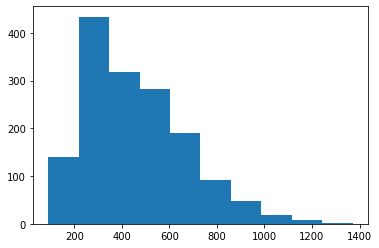

In [ ]:
from matplotlib import pyplot as plt

l = list(df['input'])
l = [el.split(' ') for el in l]
l = [len(el) for el in l]

plt.hist(l)

In [ ]:
df_save['length'] = [len(el) for el in list(df['input'].str.split(' '))]
df_save = df_save[df_save['length']<=650][['input', 'output']]
df_save.to_json('/content/drive/MyDrive/AAA_DATA/data_675.json',orient='records', lines=True)

In [ ]:
df_save=pd.read_json('/content/drive/MyDrive/AAA_DATA/data_675.json',orient='records', lines=True)
df_save

,input,output
0,SPLIT Recipe: title: labneh with fresh herbs a...,only 15 minutes is needed for the flavors to m...
1,how much cream cheese and other ingredients wi...,you will need 1 package of cream cheese and a ...
2,what are the few other ingredients?SPLIT Recip...,i attached them to my last message. they are ...
3,"thats been blended, whats next? SPLIT Recipe: ...",now transfer to a bowl and serve with the frui...
4,will i be using premade pasta from the box or ...,you will be using premade pasta. the recipe c...
...,...,...
1244,are flowers that have started to fade already ...,this pruning is to encourage flower growth.
1245,what happens if a section doesnt work.SPLIT Re...,if one of your diodes dont work we are going t...
1246,what happens to the soap if i microwave for to...,if it is heated to long it will ruin the integ...
1247,just a quick one. what about the sprouts that ...,you should go ahead and separate all of them. ...


In [ ]:
import datasets

In [ ]:
_DESCRIPTION = """\
    Description of the Wizard of Tasks Dataset to follow
"""

In [ ]:
class WizardOfTasksConfig(datasets.BuilderConfig):
    """BuilderConfig for Wizard of Tasks."""

    def __init__(self, dataset_type='general', prev_utterances=4, description=''):
        super().__init__(
            name=f"{dataset_type}_{prev_utterances}",
        )
        self.dataset_type = dataset_type
        self.prev_utterances = 4
        self.description = description

In [ ]:
class WOT(datasets.GeneratorBasedBuilder):
    DEFAULT_WRITER_BATCH_SIZE = 256
    BUILDER_CONFIGS = [WizardOfTasksConfig(dataset_type="general", prev_utterances=0, description="General Dataset"),
                       WizardOfTasksConfig(dataset_type="qa", prev_utterances=0, description="Dataset used for QA, without previous utterances"),
                       WizardOfTasksConfig(dataset_type="qa", prev_utterances=4, description="Dataset used for QA, with previous 4 utterances")]

    def _info(self):
        if self.config.dataset_type == 'general':
            print('Hello')
        else:
            print('Dataset type not supported')
        return datasets.DatasetInfo(
            description=_DESCRIPTION,
            features=datasets.Features(
                {"file": datasets.Value("string"), "label": datasets.Value("string")}
            ),
            supervised_keys=("file", "label")
        )

load_dataset('WOT') 

NameError: ignored

In [ ]:
def _split_generators(
        self, dl_manager: datasets.utils.download_manager.DownloadManager
    ):
        data_dir = dl_manager.extract(self.config.data_dir)
        if self.config.name == "clean":
            train_splits = [
                datasets.SplitGenerator(
                    name="train", gen_kwargs={"files": data_dir, "name": "train"}
                )
            ]

        return train_splits

    def _generate_examples(self, files: Union[str, os.PathLike], name: str):
        """Generate examples from a Crema unzipped directory."""
        key = 0
        examples = list()

        audio_dir = os.path.join(files, DATA_DIR[name])

        if not os.path.exists(audio_dir):
            raise FileNotFoundError
        else:
            for file in os.listdir(audio_dir):
                res = dict()
                res["file"] = "{}".format(os.path.join(audio_dir, file))
                res["label"] = file.split("_")[-2]
                examples.append(res)

        for example in examples:
            yield key, {**example}
            key += 1
        examples = []

In [ ]:
#! pip install datasets
import datasets

In [ ]:
data = datasets.load_dataset('WOT.py', 'qa_simple_0') 
data

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Dataset wot downloaded and prepared to /root/.cache/huggingface/datasets/wot/qa_simple_0/0.0.0/4ac0014048dd2eca28ec4601233204ceaac1e01447b8207a0e15602a963861eb. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['input', 'output', 'theme'],
        num_rows: 1417
    })
    test: Dataset({
        features: ['input', 'output', 'theme'],
        num_rows: 135
    })
    validation: Dataset({
        features: ['input', 'output', 'theme'],
        num_rows: 171
    })
})

In [ ]:
for i in range(171):
    print(data['validation'][i])

{'input': 'how much (1 stick) unsalted butter, should i use? SPLIT | recipe title: turkey with chile-citrus butter | recipe description: add a spark to your holiday turkey with this southwestern variation that combines the smoky spice of chipotle and ancho chiles with fresh citrus. the tangy gravy lends zing to your turkey, stuffing and mashed potatoes. | recipe ingredients: [zest and juice of 2 lemons, skins reserved, zest and juice of 2 limes, skins reserved, 1/2 cup (1 stick) unsalted butter, softened, 2 tablespoons adobo sauce (from a can of chipotle chiles en adobo), 2 tablespoons ancho chile powder, 2 teaspoons coarse sea salt, 1 (14.0-pound) turkey, neck and giblets removed, 4 cups low-sodium turkey or chicken broth, divided, 2 1/2 tablespoons all-purpose flour, 1 1/2 tablespoon chopped fresh oregano] | recipe steps: [place the citrus zests, butter, adobo sauce, chile powder, oregano and salt in a medium bowl., beat with an electric mixer until combined., slowly pour in about ha

## Analyse Labeled Data

In [ ]:
!pip install datasets
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.8/462.8 KB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 20.6 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 58.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 68.9 MB/s eta 0:00:00


In [ ]:
df = pd.read_excel('/content/Label_questions_WOT.xlsx')

# remove empty classes
df = df.dropna(subset=['Category'])

df['class'] = df['Category'].apply(lambda x: x.split(' (')[0])
df.head()

,Column1,Delete,document_url,data_split,domain,question,answer,short answer,Category,Answer not defined,...,Difficulty if other than easy,Amount of Common Sense(1-5) if other than 0,Question,Answer,Short Answer,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,class
0,0,NaN,https://www.wholefoodsmarket.com/recipes/labne...,test,cooking,Can I let the ingredients sit for longer to ma...,Only 15 minutes is needed for the flavors to m...,only 15 minutes,General Questions (Cooking),x,...,medium,2,Can I let the ingredients sit for longer to ma...,Only 15 minutes is needed for the flavors to m...,No,1.0,NaN,NaN,NaN,General Questions
1,1,a,https://www.wholefoodsmarket.com/recipes/cream...,train,cooking,How much cream cheese and other ingredients wi...,You will need 1 package of cream cheese and a ...,1 pkg. + others,Ingredients (Amount),NaN,...,NaN,NaN,How much cream cheese and other ingredients wi...,You will need 1 package of cream cheese and a ...,1 pkg. + others,1.0,NaN,NaN,NaN,Ingredients
2,2,NaN,https://www.wholefoodsmarket.com/recipes/cream...,train,cooking,What are the few other ingredients?,I attached them to my last message. They are ...,"Cashew butter, cinnamon/nutmeg, agave",Ingredients (List),NaN,...,NaN,NaN,What are the few other ingredients?,"Cashew butter, cinnamon or nutmeg, and agave n...","Cashew butter, cinnamon/nutmeg, agave",1.0,NaN,NaN,NaN,Ingredients
3,3,NaN,https://www.wholefoodsmarket.com/recipes/citru...,train,cooking,Will I be using premade pasta from the box or ...,You will be using premade pasta. The recipe c...,Premade bowtie pasta,Ingredients (Details),NaN,...,NaN,NaN,Will I be using premade pasta from the box or ...,You will be using premade pasta. The recipe ca...,Premade bowtie pasta,1.0,NaN,NaN,NaN,Ingredients
4,4,NaN,https://www.wholefoodsmarket.com/recipes/grill...,train,cooking,Will I be making the tortellini by hand or sho...,You could make it by hand but this recipe incl...,Use packaged tortellini,Ingredients (Details),NaN,...,NaN,NaN,Will I be making the tortellini by hand or sho...,You could make it by hand but this recipe incl...,Packaged tortellini,1.0,NaN,NaN,NaN,Ingredients


In [ ]:
df.groupby('class').count()['Column1']

class
Clarification         12
General Questions     51
Ingredients           82
Step Details         316
Tool                   8
Name: Column1, dtype: int64

In [ ]:
df.groupby('Category').count()['Column1']

Category
Clarification (Misunderstanding)      12
General Questions (Cooking)           12
General Questions (Ingredients)       10
General Questions (Recipe)            22
General Questions (Storage)            7
Ingredients (Amount)                  13
Ingredients (Details)                 32
Ingredients (List)                    29
Ingredients (Substitution)             8
Step Details (Duration)               73
Step Details (General)               112
Step Details (How should it look)     20
Step Details (Ingredients)            31
Step Details (Next)                   44
Step Details (Parallel)                6
Step Details (Problem)                 8
Step Details (Recommendation)          8
Step Details (Why)                    14
Tool (Details)                         3
Tool (Substitution)                    5
Name: Column1, dtype: int64

### Classification

In [ ]:
#df = df[df['class'].isin(['General Questions', 'Ingredients', 'Step Details'])]

In [ ]:
from datasets import load_dataset, DatasetDict, load_metric, load_from_disk
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, TextClassificationPipeline
import torch

from sklearn.model_selection import train_test_split

def TextClassification_with_Transformer(model_name: str, Data: pd.Series, Target:pd.Series, test_size: np.float64, max_length: int, num_labels: int, num_epochs: int, metrics_name: str, label2id: dict, id2label: dict):

    # Make data
    X = Data
    y = Target
    y = y.apply(lambda x: label2id[x])

    # Load Metrics
    metric = load_metric(metrics_name)

    # Split Data
    X_train, X_test, y_train, y_test = train_test_split(X.tolist(), y, test_size=test_size)

    # Call the Tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=True)

    # Encode the text
    train_encodings = tokenizer(X_train, truncation=True, padding=True, max_length=max_length)
    valid_encodings = tokenizer(X_test, truncation=True, padding=True, max_length=max_length)



    class MakeTorchData(torch.utils.data.Dataset):
        def __init__(self, encodings, labels):
            self.encodings = encodings
            self.labels = labels

        def __getitem__(self, idx):
            item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
            item["labels"] = torch.tensor([self.labels[idx]])
            return item

        def __len__(self):
            return len(self.labels)

    # convert our tokenized data into a torch Dataset
    train_dataset = MakeTorchData(train_encodings, y_train.ravel())
    valid_dataset = MakeTorchData(valid_encodings, y_test.ravel())


    # Call Model
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels = num_labels, label2id = label2id, id2label = id2label).to("cuda")

    # Create Metrics
    def compute_metrics(eval_pred):

        predictions, labels = eval_pred
        predictions = np.argmax(predictions, axis=1)

        # 'micro', 'macro', etc. are for multi-label classification. If you are running a binary classification, leave it as default or specify "binary" for average
        return metric.compute(predictions=predictions, references=labels, average="micro")  

    # Specifiy the arguments for the trainer  
    training_args = TrainingArguments(
        output_dir='./results',          # output directory
        num_train_epochs=num_epochs,     # total number of training epochs
        per_device_train_batch_size=8,   # batch size per device during training
        per_device_eval_batch_size=20,   # batch size for evaluation
        warmup_steps=500,                # number of warmup steps for learning rate scheduler
        weight_decay=0.01,               # strength of weight decay
        logging_dir='./logs',            # directory for storing logs
        load_best_model_at_end=True,     # load the best model when finished training (default metric is loss)
        metric_for_best_model = metrics_name,    # select the base metrics
        logging_steps=50,               # log & save weights each logging_steps
        save_steps=50,
        evaluation_strategy="steps",     # evaluate each `logging_steps`
    ) 

    # Call the Trainer
    trainer = Trainer(
        model=model,                         # the instantiated Transformers model to be trained
        args=training_args,                  # training arguments, defined above
        train_dataset=train_dataset,         # training dataset
        eval_dataset=valid_dataset,          # evaluation dataset
        compute_metrics=compute_metrics,     # the callback that computes metrics of interest
    )

    # Train the model
    trainer.train()

    # Call the summary
    trainer.evaluate()



    return trainer, model

In [ ]:
df_train = df[df['data_split'] == 'train']

#id2label = {0: "General Questions", 1: "Ingredients", 2: "Step Details", 3: "Tool", 4: "Clarification"}
#label2id = {"General Questions": 0, "Ingredients": 1, "Step Details": 2, "Tool": 3, "Clarification": 4}
#num_labels = 5
#target_variable = 'class'

id2label = {0: "Clarification (Misunderstanding)",1: "General Questions (Cooking)",2: "General Questions (Ingredients)",3: "General Questions (Recipe)",4: "General Questions (Storage)",5: "Ingredients (Amount)",             6: "Ingredients (Details)",           7: "Ingredients (List)",               8: "Ingredients (Substitution)",       9: "Step Details (Duration)",          10: "Step Details (General)",           11: "Step Details (How should it look)",12: "Step Details (Ingredients)",       13: "Step Details (Next)",              14: "Step Details (Parallel)",          15: "Step Details (Problem)",           16: "Step Details (Recommendation)",17: "Step Details (Why)",18: "Tool (Details)",19: "Tool (Substitution)"}
label2id = {"Clarification (Misunderstanding)": 0,"General Questions (Cooking)": 1,"General Questions (Ingredients)": 2,"General Questions (Recipe)": 3,"General Questions (Storage)": 4,"Ingredients (Amount)": 5,  "Ingredients (Details)": 6,        "Ingredients (List)": 7,               "Ingredients (Substitution)": 8,       "Step Details (Duration)": 9,          "Step Details (General)": 10,           "Step Details (How should it look)": 11,"Step Details (Ingredients)": 12,       "Step Details (Next)": 13,              "Step Details (Parallel)": 14,          "Step Details (Problem)": 15,           "Step Details (Recommendation)": 16,"Step Details (Why)": 17,"Tool (Details)": 18, "Tool (Substitution)": 19}
num_labels = 20
target_variable = 'Category'

sbert_trainer, sbert_model = TextClassification_with_Transformer(model_name = 'sentence-transformers/all-mpnet-base-v2', 
                                                                 Data = df_train['question'], 
                                                                 Target = df_train[target_variable], 
                                                                 test_size = 0.2, 
                                                                 max_length = 512, 
                                                                 num_labels = num_labels, 
                                                                 num_epochs = 25, 
                                                                 metrics_name ='f1',
                                                                 label2id = label2id,
                                                                 id2label = id2label)

<ipython-input-15-4983a89319fb>:15: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric(metrics_name)


Some weights of the model checkpoint at sentence-transformers/all-mpnet-base-v2 were not used when initializing MPNetForSequenceClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing MPNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MPNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of MPNetForSequenceClassification were not initialized from the model checkpoint at sentence-transformers/all-mpnet-base-v2 and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a

Step,Training Loss,Validation Loss,F1
50,2.984100,2.947447,0.341772
100,2.914000,2.812712,0.379747
150,2.730300,2.594951,0.392405
200,2.515200,2.371964,0.481013
250,2.212300,2.154616,0.556962
300,1.900400,1.920926,0.544304
350,1.599000,1.742654,0.620253
400,1.330300,1.757943,0.544304
450,0.984600,1.605011,0.594937
500,0.776500,1.487765,0.582278


***** Running Evaluation *****
  Num examples = 79
  Batch size = 20
Saving model checkpoint to ./results/checkpoint-50
Configuration saved in ./results/checkpoint-50/config.json
Model weights saved in ./results/checkpoint-50/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 79
  Batch size = 20
Saving model checkpoint to ./results/checkpoint-100
Configuration saved in ./results/checkpoint-100/config.json
Model weights saved in ./results/checkpoint-100/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 79
  Batch size = 20
Saving model checkpoint to ./results/checkpoint-150
Configuration saved in ./results/checkpoint-150/config.json
Model weights saved in ./results/checkpoint-150/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 79
  Batch size = 20
Saving model checkpoint to ./results/checkpoint-200
Configuration saved in ./results/checkpoint-200/config.json
Model weights saved in ./results/checkpoint-200/pytorch_model.bin
***** Running E

KeyboardInterrupt: ignored

In [ ]:
df_eval = df[df['data_split'].isin(['test', 'validation'])]
model_dir = '/content/results/checkpoint-550'
tokenizer_class = AutoTokenizer.from_pretrained('sentence-transformers/all-mpnet-base-v2', do_lower_case=True)
model_class = AutoModelForSequenceClassification.from_pretrained(model_dir)

def model_classify(input, model, tokenizer):
    pipe = TextClassificationPipeline(model=model, tokenizer=tokenizer)
    return pipe(input)[0]['label']

df_eval['classification'] = df_eval['question'].apply(lambda x: model_classify(x, model_class, tokenizer_class))

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--sentence-transformers--all-mpnet-base-v2/snapshots/bd44305fd6a1b43c16baf96765e2ecb20bca8e1d/vocab.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--sentence-transformers--all-mpnet-base-v2/snapshots/bd44305fd6a1b43c16baf96765e2ecb20bca8e1d/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at /root/.cache/huggingface/hub/models--sentence-transformers--all-mpnet-base-v2/snapshots/bd44305fd6a1b43c16baf96765e2ecb20bca8e1d/special_tokens_map.json
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--sentence-transformers--all-mpnet-base-v2/snapshots/bd44305fd6a1b43c16baf96765e2ecb20bca8e1d/tokenizer_config.json
loading configuration file /content/results/checkpoint-550/config.json
Model config MPNetConfig {
  "_name_or_path": "/content/results/checkpoint-550",
  "architectures": [
    "MPNetF

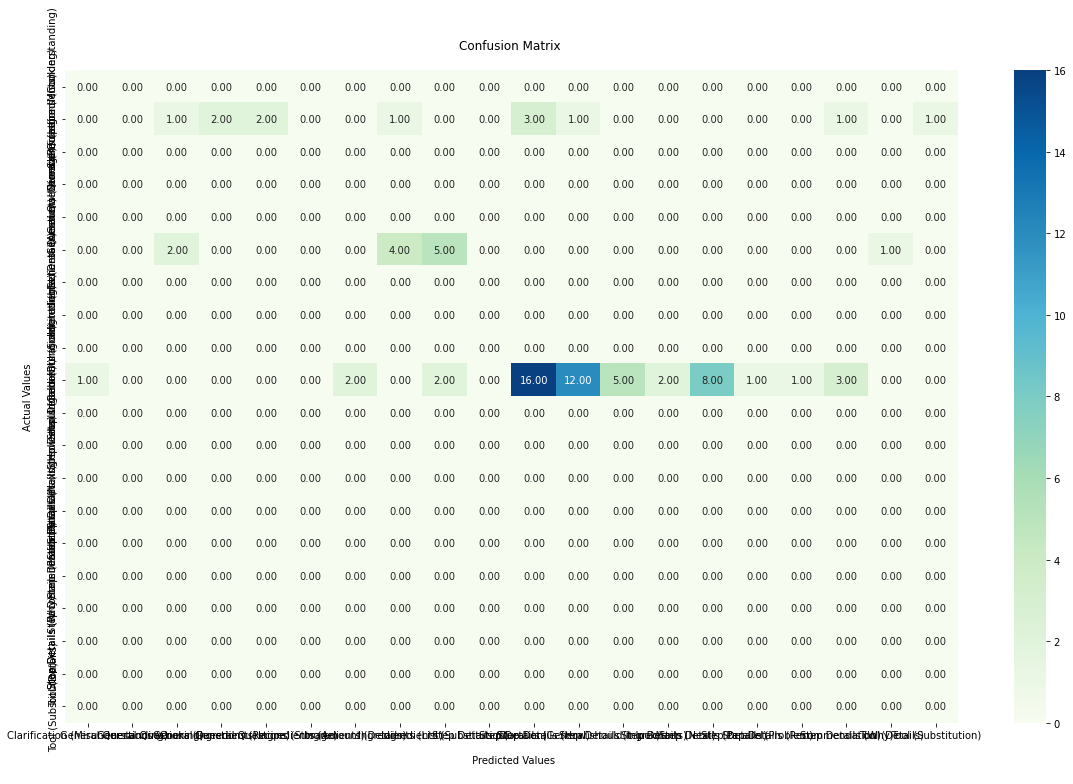

In [ ]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import seaborn as sns

y = list(df_eval['class'])
pred = list(df_eval['classification'])

plt.figure(figsize=(20,12))
fx=sns.heatmap(confusion_matrix(y,pred), annot=True, fmt=".2f",cmap="GnBu")
fx.set_title('Confusion Matrix \n');
fx.set_xlabel('\n Predicted Values\n')
fx.set_ylabel('Actual Values\n');
fx.xaxis.set_ticklabels(list(label2id.keys()))
fx.yaxis.set_ticklabels(list(label2id.keys()))
plt.show()

In [ ]:
pred

[[{'label': 'Ingredients', 'score': 0.9922349452972412}],
 [{'label': 'Ingredients', 'score': 0.9922130703926086}],
 [{'label': 'Ingredients', 'score': 0.992249608039856}],
 [{'label': 'General Questions', 'score': 0.6712608337402344}],
 [{'label': 'Ingredients', 'score': 0.9922383427619934}],
 [{'label': 'Clarification', 'score': 0.8946002125740051}],
 [{'label': 'Ingredients', 'score': 0.9922358393669128}],
 [{'label': 'Ingredients', 'score': 0.9916540384292603}],
 [{'label': 'Clarification', 'score': 0.8947063088417053}],
 [{'label': 'General Questions', 'score': 0.9663777351379395}],
 [{'label': 'General Questions', 'score': 0.9545585513114929}],
 [{'label': 'Ingredients', 'score': 0.9922583699226379}],
 [{'label': 'Ingredients', 'score': 0.9921404719352722}],
 [{'label': 'Ingredients', 'score': 0.9922066330909729}],
 [{'label': 'Ingredients', 'score': 0.9896572232246399}],
 [{'label': 'General Questions', 'score': 0.9655337333679199}],
 [{'label': 'Ingredients', 'score': 0.8928801

In [ ]:
df_train['classification'] = df_train['question'].apply(lambda x: model_classify(x, model_class, tokenizer_class))

<ipython-input-72-177422555533>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['classification'] = df_train['question'].apply(lambda x: model_classify(x, model_class, tokenizer_class))


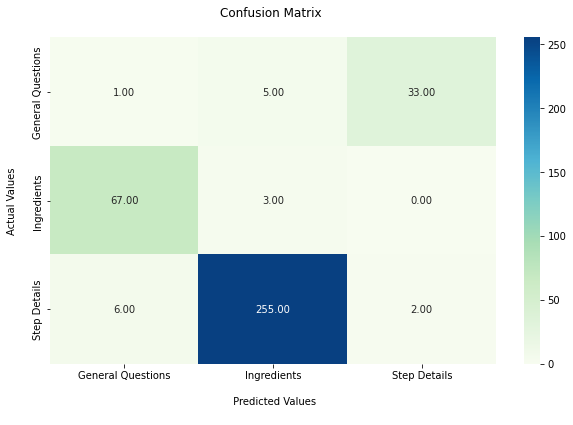

In [ ]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import seaborn as sns

y = list(df_train['class'])
pred = list(df_train['classification'])

plt.figure(figsize=(10,6))
fx=sns.heatmap(confusion_matrix(y,pred), annot=True, fmt=".2f",cmap="GnBu")
fx.set_title('Confusion Matrix \n');
fx.set_xlabel('\n Predicted Values\n')
fx.set_ylabel('Actual Values\n');
fx.xaxis.set_ticklabels(list(label2id.keys()))
fx.yaxis.set_ticklabels(list(label2id.keys()))
plt.show()

In [ ]:
df_train

,Column1,Delete,document_url,data_split,domain,question,answer,Category,Answer not defined,History required,Difficulty if other than easy,Amount of Common Sense(1-5) if other than 0,class,classification
1,1,a,https://www.wholefoodsmarket.com/recipes/cream...,train,cooking,How much cream cheese and other ingredients wi...,You will need 1 package of cream cheese and a ...,Ingredients (Amount),NaN,NaN,NaN,NaN,Ingredients,General Questions
2,2,NaN,https://www.wholefoodsmarket.com/recipes/cream...,train,cooking,What are the few other ingredients?,I attached them to my last message. They are ...,Ingredients (List),NaN,NaN,NaN,NaN,Ingredients,General Questions
3,3,NaN,https://www.wholefoodsmarket.com/recipes/citru...,train,cooking,Will I be using premade pasta from the box or ...,You will be using premade pasta. The recipe c...,Ingredients (Details),NaN,NaN,NaN,NaN,Ingredients,General Questions
4,4,NaN,https://www.wholefoodsmarket.com/recipes/grill...,train,cooking,Will I be making the tortellini by hand or sho...,You could make it by hand but this recipe incl...,Ingredients (Details),NaN,NaN,NaN,NaN,Ingredients,General Questions
5,5,NaN,https://www.wholefoodsmarket.com/recipes/grill...,train,cooking,Should the tortellini be fresh or can I use fr...,"Don't worry, the recipe calls for preprepared ...",Ingredients (Details),NaN,NaN,NaN,NaN,Ingredients,General Questions
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
473,473,a,https://www.wholefoodsmarket.com/recipes/cream...,train,cooking,Could you let me know if this is a savory dish...,Good question! There is no sugar listed in the...,General Questions (Recipe),NaN,NaN,medium-hard,2,General Questions,Step Details
474,474,NaN,https://www.wholefoodsmarket.com/recipes/cream...,train,cooking,Should I add the cottage cheese directly to th...,"No, that comes later. Boil the broth with the ...",Step Details (General),NaN,NaN,NaN,NaN,Step Details,Ingredients
475,475,NaN,https://www.wholefoodsmarket.com/recipes/cream...,train,cooking,Is this the first step in the recipe? Do I nee...,"No that is the first step, just make sure you ...",Step Details (Next),NaN,NaN,NaN,NaN,Step Details,Ingredients
476,476,a,https://www.wholefoodsmarket.com/recipes/cream...,train,cooking,How long should I boil the broth for?,"About 45 minutes, the next step is attached.",Step Details (Duration),NaN,NaN,NaN,NaN,Step Details,Ingredients


#Experiment


ingredient question
current task question
step question
general cooking or DIY question
other domain question
chit chat
system capabilities question
current viewing options question
ingredient substitution


array(['ingredient question', 'step question', 'ingredient substitution',
       'current task question'], dtype=object)

https://www.seriouseats.com/gimbap-korean-seaweed-rice-rolls


0.41586867305061564


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.8/152.8 KB 8.6 MB/s eta 0:00:00


{'rouge-1': {'r': 0.05281344106743271,
  'p': 0.10005116268814909,
  'f': 0.0638445794749578},
 'rouge-2': {'r': 0.020925219031105446,
  'p': 0.04007101346142441,
  'f': 0.025332544680135606},
 'rouge-l': {'r': 0.05116421455667543,
  'p': 0.09731581964458687,
  'f': 0.06194940044869704}}

In [ ]:
results_qa

["Question: How much rice is needed for the recipe?   Answer (true): 3 cups of rice are needed for the recipe.  Answer (generated): b'\n\nthree cups'",
 " What is the ratio of water to rice when cooking the rice?   Answer (true): The ratio of water to rice is 2:1.  Answer (generated): b'\n5three hundred and fortyg) cucumber\nSea or kosher salt'",
 " What kind of fish is used in the recipe?   Answer (true): Sashimi-grade tuna or salmon is used in the recipe.  Answer (generated): b'\n\x05sushi'",
 " How should the rice be seasoned?   Answer (true): The rice should be seasoned with sesame oil, salt, and sugar.  Answer (generated): b'\n\x0bin ten days'",
 " How long should the rice be cooled for before assembling the kimbap?   Answer (true): The rice should be cooled for at least 30 minutes before assembling the kimbap.  Answer (generated): b'\n\x12one to two minutes'",
 " What can be used as a substitute for the sesame oil?   Answer (true): Vegetable oil can be used as a substitute for se

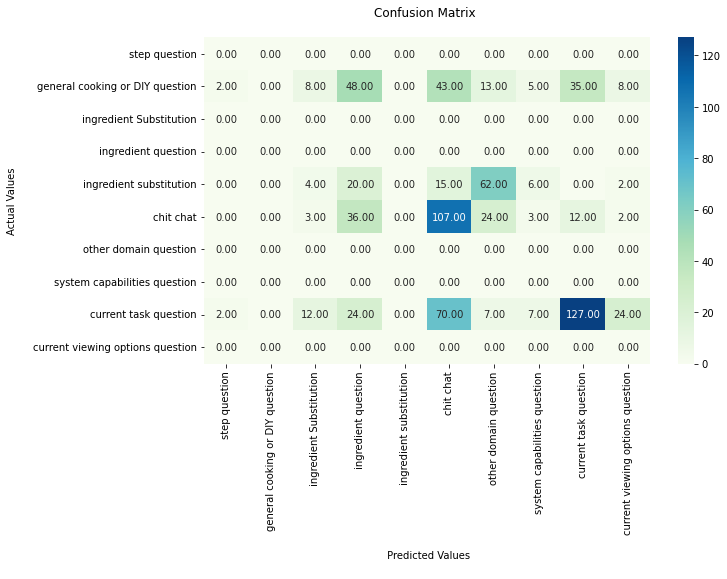